<div dir="rtl">

<h3>🎯 أهداف الدرس</h3>
<ul>
  <li>بناء نموذج <b>CART</b> لتصنيف الغطاء الأرضي لأربع فئات: مياه، غطاء خضري، عمران، أرض جرداء.</li>
  <li>استخدام Sentinel-2 مع المؤشرات الطيفية: <b>NDVI, MNDWI, NDBI</b>.</li>

</ul>

<h3>📌 خطوات العمل </h3>
<ul>
  <li>تحديد منطقة الدراسة AOI.</li>
  <li>تحميل Sentinel-2 وإجراء Preprocessing (cloud masking, rescaling) باستخدام eemont.</li>
  <li>حساب المؤشرات الطيفية: NDVI, MNDWI, NDBI.</li>
  <li>إضافة المؤشرات كباندات إلى الصورة النهائية.</li>
  <li>تحميل بيانات ESRI LULC وتجهيزها كطبقة labels.</li>
  <li>جمع عينات التدريب.</li>
  <li>بناء نموذج CART وتطبيقه على الصورة.</li>
  <li>عرض الخريطة المصنفة.</li>
</ul>

<p>🔸 تقييم النموذج وقياس الدقة سيتم شرحه في الفيديو القادم.</p>

</div>


## The Workflow
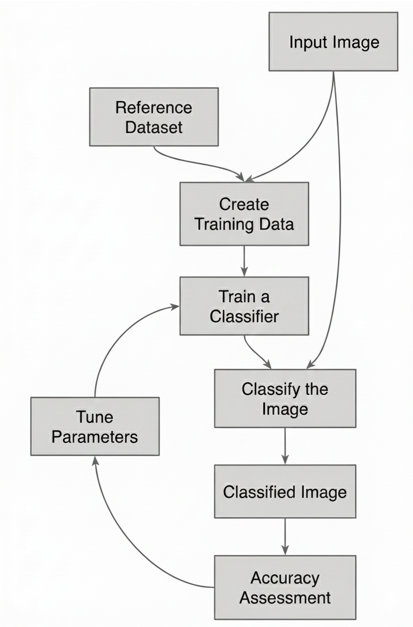

<div dir="rtl">

<h3>خوارزمية <b>CART</b> (Classification and Regression Trees)</h3>

<p>
تُعَدّ خوارزمية <b>CART</b> من أبسط وأوضح خوارزميات تعلم الآلة، وتعتمد على بناء شجرة قرار تقوم بتقسيم البيانات خطوة بعد خطوة للوصول إلى أفضل فصل بين الفئات أو أفضل توقع للقيم.
</p>

<h4>⭐ مميزات خوارزمية CART</h4>
<ul>
  <li>سهلة الفهم والشرح، ويمكن تمثيلها بصريًا في شكل شجرة Decision Tree.</li>
  <li>لا تحتاج إلى خطوات إعداد بيانات كثيرة مثل <b>normalization</b> أو <b>standardization</b>.</li>
  <li>تعمل بشكل جيد مع العلاقات غير الخطية ومع البيانات التي تحتوي على Features رقمية وفئوية في نفس الوقت.</li>
  <li>مناسبة جدًا للمبتدئين كنقطة بداية قبل الانتقال لخوارزميات أكثر قوة وتعقيدًا.</li>
  <li> يمكن استخدامها في التصنيف والانحدار <b>classification and regression<b>
</ul>

<h4>⚠️ عيوبها</h4>
<ul>
  <li>قد تسبب <b>overfitting</b> إذا لم يتم ضبط النموذج أو استخدام <b>pruning (التقليم)</b>.</li>
  <li>غير مستقرة نسبيًا، لأن تغيّرًا بسيطًا في البيانات قد ينتج عنه شجرة مختلفة بالكامل.</li>
  <li>قد تتأثر بالقيم الشاذة Outliers.</li>
</ul>

<h4>🌱 استخداماتها في الزراعة والبيئة</h4>
<ul>
  <li>تصنيف الغطاء الأرضي Land Cover Classification مثل: حقول، مباني، مياه، نبات طبيعي.</li>
  <li>تمييز أنواع المحاصيل أو مستويات صحة النبات باستخدام NDVI أو مؤشرات Vegetation Indices أخرى.</li>
  <li>رصد التغيرات البيئية أو تحديد المناطق المعرضة للتدهور.</li>
  <li>اختبار نموذج بسيط قبل استخدام Random Forest أو SVM.</li>
</ul>

<h4>🎯 لماذا نبدأ بـ CART قبل Random Forest؟</h4>
<p>
لأن CART تمثل الفكرة الأساسية التي يبنى عليها Random Forest.  
فهم طريقة اتخاذ القرار داخل شجرة واحدة يساعدك على فهم كيف يعمل نموذج مكوّن من مئات الأشجار بطريقة أفضل وأكثر وضوحًا.
</p>

</div>


In [ ]:
# Install and Import Libraries
!pip install eemont

import ee
import geemap
import eemont


In [ ]:
# Authenticate to Earth Engine.
ee.Authenticate()

# Initialize Earth Engine with your project ID
ee.Initialize(project =  'ee-nouribrahim25')

DEFINE AREA OF INTEREST (AOI)

In [ ]:
coors = [[30.497534, 31.171094],
    [30.497534, 31.217202],
    [30.586283, 31.217202],
    [30.586283, 31.171094],
    [30.497534, 31.171094]]

aoi = ee.Geometry.Polygon(coors)


In [ ]:
# Create an Interactive Map
Map = geemap.Map(width = 800)
Map.add_basemap('HYBRID')
Map.centerObject(aoi , 12)
Map.add_layer(aoi , {} , 'AOI')


LOAD AND PREPROCESS SENTINEL-2 DATA

In [ ]:
# Date Range
start_date = '2025-01-01'
end_date = '2025-05-01'

s2 = (ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
      .filterBounds(aoi)
      .filterDate(start_date , end_date)
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
      .preprocess()      #eemont preprocessing (cloud masking + scaling)
      .spectralIndices(['NDVI', 'NDBI', 'MNDWI'])
      .median()
      .clip(aoi)
      )
s2

In [ ]:
# Define bands for classification
bands = ['B2', 'B3', 'B4', 'B8', 'B11', 'NDVI', 'MNDWI','NDBI']
label = 'landcover'

image = s2.select(bands)

In [ ]:
image

In [ ]:
# Visualize s2 composite
vis_params = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'],
}

Map.add_layer(image, vis_params, 'Sentinel-2 RGB')
Map

LOAD AND REMAP Dynamic World V1

https://developers.google.com/earth-engine/datasets/catalog/GOOGLE_DYNAMICWORLD_V1#bands


In [ ]:
dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
        .filterBounds(aoi)
        .filterDate(start_date , end_date)
        .select('label')
        .mode()
        .clip(aoi)
      )


In [ ]:
dw.getInfo()

In [ ]:
# Remapping Based DYNAMIC WORLD CLASS :
# Dynamic World Classes (0-8):
# 0 = Water , 1 = Trees, 2 = Grass , 3 = Flooded Vegetation, 4 = Crops
# 5 = Shrub and Scrub , 6 = Built Area , 7 = Bare Ground, 8 = Snow and Icend

# Target classes: 0=Water, 1=Vegetation, 2=Bare_Soil, 3=Urban

dw_remapped = dw.remap(
                [0, 1, 2, 3, 4, 5, 6, 7, 8],  # Dynamic World classes
                [0, 1, 1, 1, 1, 1, 3, 2, 2]  # Target: water, veg, veg, veg, veg, veg, urban, bare, bare
                ).rename(label)

dw_remapped.getInfo()

In [ ]:
dw_vis = {
  "names": [
    "Water",
    "Vegetation",
    "Bare_Soil",
    "Urban"
   ],
  "colors": [
    "blue",
    "green",
    "yellow",
    "red",
  ]}

Map.addLayer(dw_remapped, {'min':0, 'max':3, 'palette':dw_vis['colors']}, 'DW LULC', False)
Map

In [ ]:
# Check Projection
print('Image projection:', image.projection().getInfo())
print('Esri projection:', dw_remapped.projection().getInfo())

CREATE TRAINING SAMPLES

In [ ]:
# Add the landcover band to the image for sampling
image_with_labels = image.addBands(dw_remapped)

# generate random samples (stratified by class)
sample_size = 500           # points per class

training = image_with_labels.stratifiedSample(
    numPoints=sample_size,
    classBand='landcover',
    region=aoi,
    scale= 10,
    projection=image.projection(),
    seed= 42,
    geometries=True
)

Map.addLayer(training, {}, 'samples', False)
print(training.size().getInfo())
print(training.first().getInfo())
Map

SPLIT DATA: TRAINING AND VALIDATION

In [ ]:
# Add random column for splitting
training = training.randomColumn('random', seed=42)

# 70% training, 30% validation
training_set = training.filter(ee.Filter.lt('random', 0.7))
validation_set = training.filter(ee.Filter.gte('random', 0.7))

print('Training samples:', training_set.size().getInfo())
print('Validation samples:', validation_set.size().getInfo())

TRAIN CART CLASSIFIER

In [ ]:
classifier = ee.Classifier.smileCart().train(
    features=training_set,
    classProperty=label,
    inputProperties=bands
)

classifier

CLASSIFY THE IMAGE

In [ ]:
classified = image.classify(classifier)

class_vis = {'min':0 , 'max':3 , 'palette': ["#0000FF","#00FF00","#FFFF00","#FF0000",]}
# Add legend
legend_dict = {
    'Water': '#0000FF',
    'Vegetation': '#00FF00',
    'Bare Soil': '#FFFF00',
    'Urban': '#FF0000'
}
#Visualize classified map
Map.remove_legends()  # Clear any existing legends
Map.addLayer(classified, class_vis, 'CART Classification')
Map.add_legend(
    title="Land Cover Classes",
    legend_dict=legend_dict,
    position='bottomright'
)

Map


ACCURACY ASSESSMENT

In [ ]:
# Validate on validation set
validated = validation_set.classify(classifier)

*Train Accuracy*


In [ ]:
# Train Accuracy

# Confusion Matrix
train_accuracy = classifier.confusionMatrix()

print("\n=== Training Accuracy ===")
train_accuracy_list = train_accuracy.getInfo()
# Pretty print as a table
for row in train_accuracy_list:
    print(row)

# Accuracy metrics
print("\nOverall Accuracy:", train_accuracy.accuracy().getInfo())
print("Kappa:", train_accuracy.kappa().getInfo())
print("Producer Accuracy (Recall):", train_accuracy.producersAccuracy().getInfo())
print('Consumer\'s Accuracy (Precision):', train_accuracy.consumersAccuracy().getInfo())
print('F1 Scores:', train_accuracy.fscore().getInfo())

*Test Accuracy*

In [ ]:
# Test Accuracy

# Confusion Matrix
validation_accuracy = validated.errorMatrix('landcover', 'classification')

print("\n=== Confusion Matrix ===")
validation_accuracy_list = validation_accuracy.getInfo()

# Pretty print as a table
for row in validation_accuracy_list:
    print(row)

# Accuracy metrics
print("\nOverall Accuracy:", validation_accuracy.accuracy().getInfo())
print("Kappa:", validation_accuracy.kappa().getInfo())
print("Producer Accuracy (Recall):", validation_accuracy.producersAccuracy().getInfo())
print('Consumer\'s Accuracy (Precision):', validation_accuracy.consumersAccuracy().getInfo())
print('F1 Scores:', validation_accuracy.fscore().getInfo())


EXPORT THE CLASSIFIED IMAGE TO GOOGLE DRIVE

In [ ]:
export_classified = ee.batch.Export.image.toDrive(
    image=classified.uint8(),      # convert to unsigned 8-bit
    description='CART_classified_image',
    folder='GEE_Exports',          # Your folder in Google Drive
    fileNamePrefix='cart_lulc',
    scale=10,
    region=aoi,
    maxPixels=1e13
)

export_classified.start()

EXPORT METRICS TABLE TO GOOGLE DRIVE (CSV)

In [ ]:
# Convert confusion matrix to a feature collection

validation_accuracy_table = ee.FeatureCollection([
    ee.Feature(None, {
        'matrix': validation_accuracy.getInfo(),
        'overall_accuracy': validation_accuracy.accuracy(),
        'kappa': validation_accuracy.kappa(),
        'producer_accuracy': validation_accuracy.producersAccuracy(),
        'user_accuracy': validation_accuracy.consumersAccuracy(),
        'F1 Scores:': validation_accuracy.fscore()
    })
])

# Export matrics table
export_metrics = ee.batch.Export.table.toDrive(
    collection=validation_accuracy_table,
    description='CART_accuracy_metrics',
    folder='GEE_Exports',
    fileNamePrefix='accuracy_metrics',
    fileFormat='CSV'
)
export_metrics.start()